In [ ]:
hw_done = False    ## change this to True to mark your homework as done.

### ASTR-324, University of Washington
# Homework 3


## Problem

Using the functions shown in class (and copied below), examine the accuracy of various ways to estimate the flux of an object.

1. Generate a few (say, three) simulated image of a star using the `simulatedImage` function for different seed values, and visualize them using plotCutout. Run `psfPhot` and `apPhot` on every simulated image, and print the estimated flux.

2. Generate a thousand different simulated images using `simulatedImage`, and compute `psfPhot`, and `apPhot` for each simulated image. Plot the histogram of estimates for each (two histogram in total), as well as the mean (using `np.average`) and standard deviation (with `np.std`).

3. Some of the estimates above will be biased, and standard deviations (which are the measure of the precision of the estimate) are not directly comparable. To make them comparable, multiply the standard deviations by `Atrue/Amean` (were `Amean` is the mean computed above). This mimics what would happen if we were to remove the bias by calibrating with standard stars. What do you observe about the recalibrated standard deviations? Which one is smaller and why?

4. Extend the `psfPhot` function to perform a brute force grid search for the maximum likelihood value of both `A` and `skyBg`. Search for optimal `skyBg` value in a 890 ≤ skyBg < 930 range, with a step size of 0.1 (keep the range for `A` the same as in the present function). Have your modified function return:

  * The maximum likelihood estimates of the flux and sky level
  * 1D numpy arrays with the grid of tested $A$ and $skyBg$ values
  * 2D numpy array with the computed chi2 for the corresponding value of $A$ an $skyBg$ (i.e., where `chi2[i, j]` is the $\chi^2$ for `A[i]`, `skyBg[j]`)

   For an image simulated with `seed=42` (i.e., generated by running `image = simulatedImage(42)`), run your newly extended function. Print out the ML estimate for `A` and `skyBg`, and visualize the likelihood surface using the `plotLikelihood` function (defined below).

## Solution

In [1]:
%matplotlib inline

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=False)

import numpy as np
import math
import matplotlib.pyplot as plt

def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./sigmaPSF) / (2*math.pi*sigmaPSF)
    return psf

def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None, clim=(800, 1300)):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] // 2.

    if title is None:
        title = "min = %.1f, max=%.1f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(*clim)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

In [2]:
Atrue = 3000.12   # the true source flux
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid |
muYtrue = 0.0     # source y centroid
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 912.33    # sky background (photons / second)

In [3]:
def simulatedImage(seed):
    np.random.seed(seed)

    image = np.zeros((xdim, ydim))
    image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
    image += skyBg
    image = np.random.poisson(image)

    return image

### Task 1

In [4]:
def apPhot(image, r = 3, x0=0, y0=0):
    # Compute the aperture magnitude
    xx = np.arange(image.shape[0]) - image.shape[0]/2.+0.5
    yy = np.arange(image.shape[1]) - image.shape[1]/2.+0.5
    
    rpix = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    apPhotImage = image - skyBg
    apPhotImage[rpix > r] = 0

    return apPhotImage.sum()

def psfPhot(image, Amin = 2200, Amax = 3800):
    """ Perform PSF photometry with a PSF=N(x=0,y=0,\sigma=sigmaPSF)"""
    testA = np.arange(Amin, Amax)
    chi2 = np.empty(len(testA))
    best = (np.nan, np.inf) # will store the currently best A, and the corresponding chi2
    psf = makePSF(image.shape, 0, 0, sigmaPSF)
    for i, A in enumerate(testA):
        model = A*psf + skyBg
        chi2[i] = np.sum((image - model)**2 / model)
        if chi2[i] < best[1]:
            best = (A, chi2[i])
    return best[0]

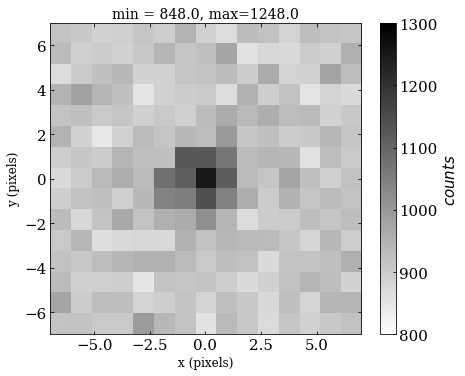

psfPhot = 2887
 apPhot = 2600.4299999999985


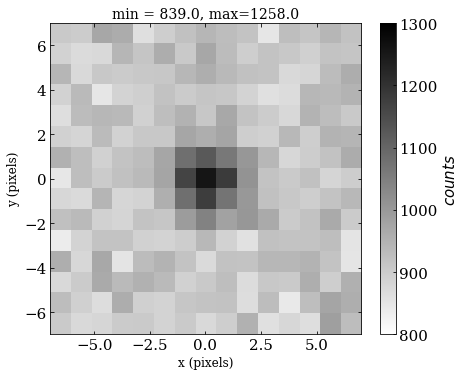

psfPhot = 3216
 apPhot = 3037.4299999999985


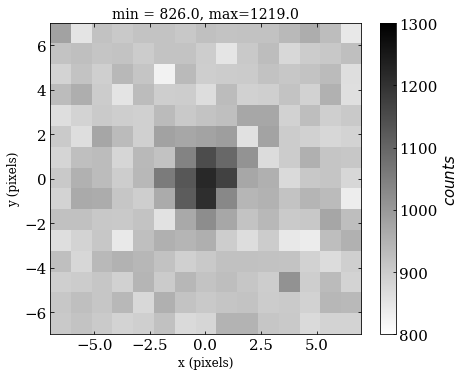

psfPhot = 3112
 apPhot = 2878.4299999999985


In [5]:
for i in range(3):
    image = simulatedImage(i)
    plotCutout(image)
    plt.show()

    print("psfPhot =", psfPhot(image))
    print(" apPhot =", apPhot(image))

### Task 2/3

apPhot 2856.9319999999993 169.0 , equivalent to 3000.12 +/- 177.470
psfPhot 3018.887 144.0 , equivalent to 3000.12 +/- 143.105


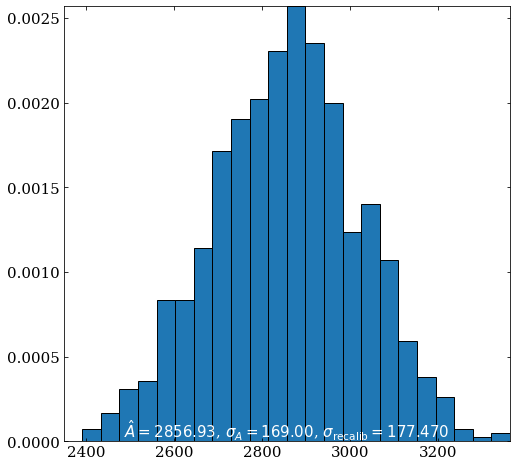

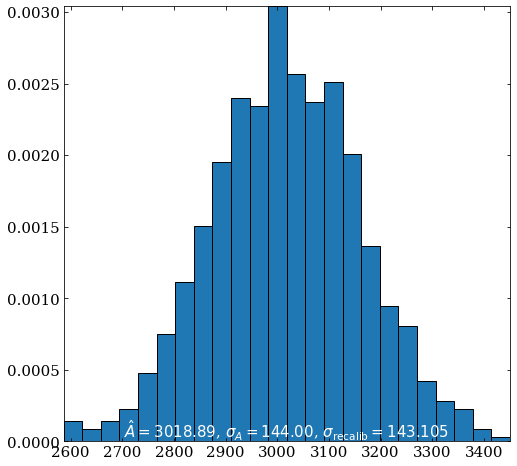

In [7]:
def runSimulation(photMethod, repeats=1000):
    A = np.empty(repeats, float)
    for i in range(A.size):
        image = simulatedImage(i)
        A[i] = photMethod(image)

    Amean = np.average(A)
    Astdev = np.floor(np.std(A, ddof=1))

    return Amean, Astdev, A

def makeHist(photMethod):
    Amean, Astdev, A = runSimulation(photMethod, 1000)
    bins = np.linspace(Amean - 3*Astdev, Amean + 3*Astdev, 25)-0.5
    fig, ax = plt.subplots(figsize=(8,8))
    n, bins, patches = ax.hist(A, bins, density=True)
    ax.text(0.5, 0.025, r"$\hat A = %.2f$, $\sigma_A = %.2f$, $\sigma_{\rm recalib} = %.3f$" % (Amean, Astdev, Astdev * Atrue / Amean), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='white')

    print(photMethod.__name__, Amean, Astdev, ', equivalent to %.2f +/- %.3f' % (Atrue, Astdev * Atrue / Amean))

makeHist(apPhot)
makeHist(psfPhot)

What do you observe about the recalibrated standard deviations? Which one is smaller and why?

The histogram of PSF photometry estimates is narrower, meaning the precion of the PSF measurements is higher than the aperture photometry.

This is what we'd expect from theory, given that PSF photometry is a Maximum Likelihood estimator, and those are guaranteed to (asymptotically) have the highest precision (i.e., they asymptotically approach the [Cramer-Rao bound](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93Rao_bound)).

### Task 4

In [8]:
image = simulatedImage(42)

In [9]:
def psfPhotAndSky(image, Amin = 2200, Amax = 3800, skyBgMin = 890, skyBgMax=930):
    """ Perform PSF photometry with a PSF=N(x=0,y=0,\sigma=sigmaPSF)"""
    testA = np.arange(Amin, Amax)
    testSkyBg = np.arange(skyBgMin, skyBgMax, 0.1)
    chi2 = np.empty((len(testA), len(testSkyBg)))
    best = (None, None, np.inf) # stores the best A, skyBg, and chi2
    psf = makePSF(image.shape, 0, 0, sigmaPSF)
    for i, A in enumerate(testA):
        for j, skyBg in enumerate(testSkyBg):
            model = A*psf + skyBg
            chi2[i, j] = np.sum((image - model)**2 / model)
            if chi2[i, j] < best[2]:
                best = (A, skyBg, chi2[i, j])

    return best, chi2, (testA, testSkyBg)

In [10]:
(mlA, mlSkyBg, mlChi2), chi2, (testA, testSkyBg) = psfPhotAndSky(image)
print('MLE(A, skyBg) = %.2f %.2f' % (mlA, mlSkyBg))
print('χ²/dof = %.2f' % (mlChi2 / (image.size - 2)))

MLE(A, skyBg) = 2853.00 913.30
χ²/dof = 1.17


In [11]:
def plotLikelihood(Arange, skyBgRange, chi2, Atrue, skyBgTrue, mlA, mlSkyBg):
    """
    A function to visualize the 2D likelihood surface

    Inputs:
      Arange:           range of A values (1D numpy array)
      skyBgRange:       range of skyBg values (1D numpy array)
      lnL:              log likelihood (2D numpy array of (len(A), len(skyBg)) shape)
      Atrue, skyBgTrue: true value of A, skyBg
      ml, mlSkyBg:      ML value of A, skyBg
    """

    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(left=0.08, bottom=0.15, right=0.95, top=0.90, wspace=0.29, hspace=0.46)

    ## renormalize for clean plotting
    lnL = -0.5*chi2
    lnL -= lnL.max()

    ## lnL image 
    ax = fig.add_axes([0.35, 0.35, 0.45, 0.6], xticks=[], yticks=[])
    ax.set_title('ln(L) image', fontsize=14)
    # pretty color map
    plt.imshow(lnL, origin='lower',
               extent=(skyBgRange[0], skyBgRange[-1], Arange[0], Arange[-1]),
               vmin=-4, vmax=0,
               cmap=plt.cm.RdYlGn,
               aspect='auto')

    # mark true values     
    ax.plot(skyBgTrue, Atrue, 'o', color='red', alpha=0.75)
    # mark ML solution: (mlSkyBg, mlA)
    ax.plot(mlSkyBg, mlA, 'x', color='white', alpha=0.99, lw=35)

    # colorbar
    cax = plt.axes([0.82, 0.35, 0.02, 0.6])
    cb = plt.colorbar(cax=cax)
    cb.set_label(r'$lnL({\rm skyBg}, A)$', fontsize=14)

    # marginal projections
    p_sigma = np.exp(lnL).sum(0)
    p_A = np.exp(lnL).sum(1)
  
    ax1 = fig.add_axes([0.35, 0.1, 0.45, 0.23], yticks=[])
    ax1.plot(skyBgRange, p_sigma, '-k')
    ax1.set_xlabel(r'${\rm skyBg}$ (pixel)', fontsize=12)
    ax1.set_ylabel(r'$p({\rm skyBg})$', fontsize=12)
    ax1.set_xlim(np.min(skyBgRange), np.max(skyBgRange))

    ax2 = fig.add_axes([0.15, 0.35, 0.18, 0.6], xticks=[])
    ax2.plot(p_A, Arange, '-k')
    ax2.set_ylabel(r'$A$ (counts)', fontsize=12)
    ax2.set_xlabel(r'$p(A)$', fontsize=12)
    ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse x axis
    ax2.set_ylim(np.min(Arange), np.max(Arange))

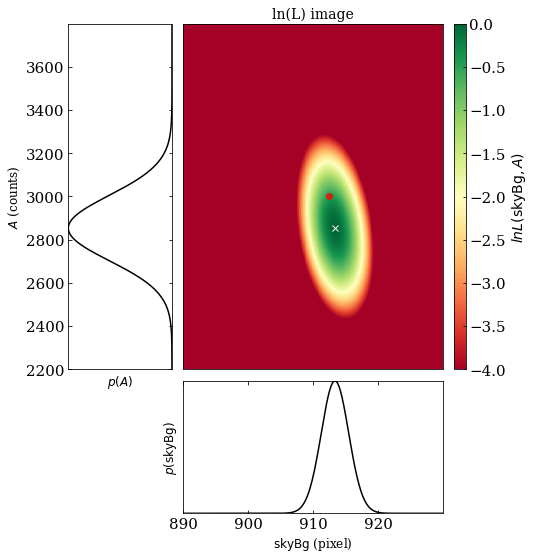

In [12]:
plotLikelihood(testA, testSkyBg, chi2, Atrue, skyBg, mlA, mlSkyBg)